# Australia Plauge Locust Modeling

This section covers the spatial modeling for australian plague locusts

- section 1: data management
- section 2: outbreak modeling
- section 3: nil-observatiom modeling
- section 4: outbreak and mean annual preciptation modeling

We will do basic modeling and saving relevant data to disk 

Another notebook later in the series will create mansucript figures and tables

# Section 1 - Data management

In [ ]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("mgcv", "gratia", "sf","rnaturalearth",
              "ggpubr", "patchwork", "broom", "knitr", "janitor", 
              "here","ggpubr","MetBrewer","GGally","tidyverse")

load_packages(packages)

i_am('README.md')


# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10,repr.matrix.max.rows=10)


## read in data

- filter species for APL
- manage data into long format
- select variables used for modeling
- create outbreak and nil observation datasets

In [48]:
apl_dat <- read_csv(here('data/processed/spatial_modeling/apl_survey_remote_sense_data.csv'),show_col_types = FALSE)

In [49]:
apl_locust_dat <- apl_dat |>
    clean_names() |>
  mutate(adult_density = str_remove_all(adult_density, "[{}]"),
         nymph_density = str_remove_all(nymph_density, "[{}]")) %>%
  separate_rows(adult_density, sep = ", ") %>%
  separate(adult_density, into = c("adult_density", "adult_density_count"), sep = ": ") %>%
  separate_rows(nymph_density, sep = ", ") %>%
  separate(nymph_density, into = c("nymph_density", "nymph_density_count"), sep = ": ") %>%
  mutate(across(c(adult_density, adult_density_count, nymph_density, nymph_density_count), as.numeric)) |> 
  distinct() |>
  group_by(polygon_id,species) |>
  mutate(total_observations = n()) 


In [51]:
unique(apl_locust_dat$ecoregion)

[1] "Great Victoria desert"                
 [2] "Central Ranges xeric scrub"           
 [3] "Tirari-Sturt stony desert"            
 [4] "Simpson desert"                       
 [5] "Great Sandy-Tanami desert"            
 [6] "Mitchell Grass Downs"                 
 [7] "Carpentaria tropical savanna"         
 [8] "Flinders-Lofty montane woodlands"     
 [9] "Murray-Darling woodlands and mallee"  
[10] "Southeast Australia temperate savanna"
[11] "Naracoorte woodlands"                 
[12] "Southeast Australia temperate forests"
[13] "Eastern Australia mulga shrublands"   
[14] "Brigalow tropical savanna"            
[15] "Eastern Australian temperate forests" 
[16] "Eyre and York mallee"

In [53]:
apl_outbreak_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 4) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev,ecoregion) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2,
          ecoregion = factor(ecoregion)) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev))  |>
    distinct()

apl_nil_dat <- apl_locust_dat |>
    ungroup() |>
    filter(species == 11 & nymph_density == 0) |>
    select(polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,
           nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev,ecoregion) |>
    group_by(polygon_id) |>
    mutate(nitrogen = sum(nto_nto_005_015_ev,nto_nto_000_005_ev)/2, 
           phosphorus = sum(pto_pto_005_015_ev,pto_pto_000_005_ev)/2,
          ecoregion = factor(ecoregion)) |>
    select(!c(nto_nto_000_005_ev,nto_nto_005_015_ev,pto_pto_005_015_ev,pto_pto_000_005_ev)) |>
    distinct()

### save to disk for further use

In [54]:

write.csv(apl_outbreak_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),row.names=FALSE)

write.csv(apl_nil_dat,here('data/processed/spatial_modeling/spatial_modeling_locust_nil_model_data.csv'),row.names=FALSE)


# Section 2 - outbreak modeling

In [96]:
outbreak_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_outbreak_model_data.csv'),
                          show_col_types = FALSE) |>
    mutate(ecoregion = factor(ecoregion)) |>
    filter(nymph_density_total_count <= 50)

In [97]:
summary(outbreak_data)

   polygon_id        longitude        latitude      nymph_density
 Min.   : 162921   Min.   :137.0   Min.   :-37.57   Min.   :4    
 1st Qu.: 437692   1st Qu.:139.7   1st Qu.:-34.45   1st Qu.:4    
 Median :1009186   Median :143.0   Median :-32.53   Median :4    
 Mean   : 985052   Mean   :142.9   Mean   :-32.25   Mean   :4    
 3rd Qu.:1494327   3rd Qu.:146.0   3rd Qu.:-31.04   3rd Qu.:4    
 Max.   :2092645   Max.   :151.3   Max.   :-21.08   Max.   :4    
                                                                 
 nymph_density_count nymph_density_total_count
 Min.   : 1.000      Min.   : 1.000           
 1st Qu.: 1.000      1st Qu.: 1.000           
 Median : 1.000      Median : 1.000           
 Mean   : 1.545      Mean   : 2.302           
 3rd Qu.: 1.000      3rd Qu.: 2.000           
 Max.   :24.000      Max.   :50.000           
                                              
                                 ecoregion       nitrogen      
 Southeast Australia temperate s

## Raw data visualization

In [98]:
head(outbreak_data,1)
nrow(outbreak_data)

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,ecoregion,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
162921,137.1195,-33.36002,4,1,1,Eyre and York mallee,0.07035461,0.02197414


[1] 6640

In [99]:
aus <- ne_states(country = 'Australia')


map_dat <- outbreak_data |>
    select(polygon_id,latitude,longitude,nymph_density_count) |>
    st_as_sf(coords = c('longitude','latitude'),
                   crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

outbreak_point_map <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat) +
        theme_void() 



`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


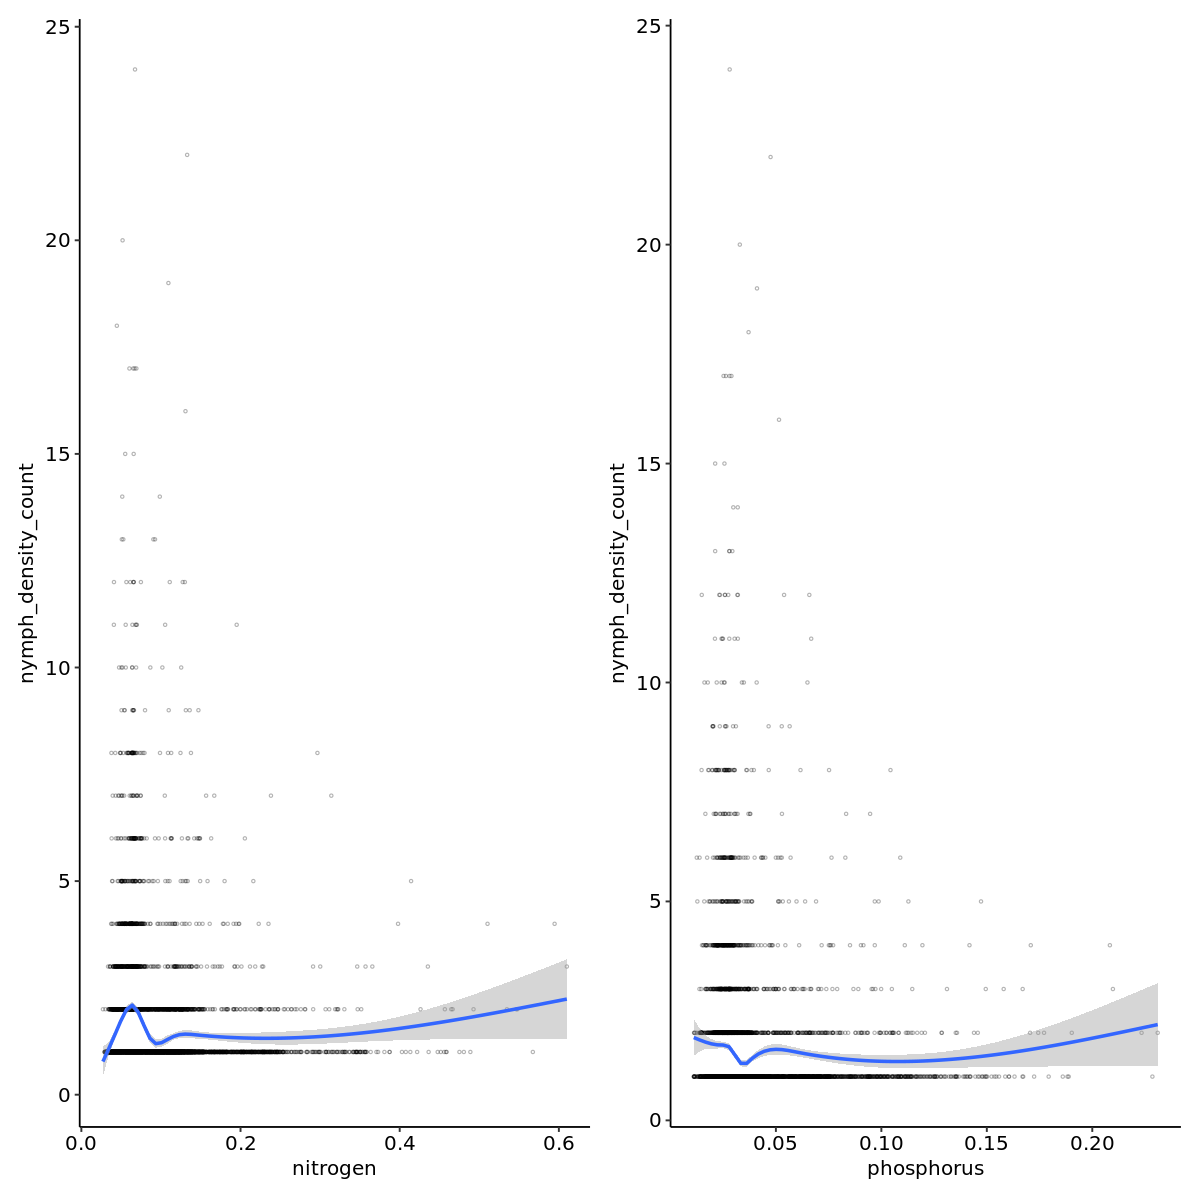

In [100]:
nto_plot <- outbreak_data |>
    ggplot(aes(x=nitrogen,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

pto_plot <- outbreak_data |>
    ggplot(aes(x=phosphorus,y=nymph_density_count)) +
        geom_point(pch=21,alpha=0.3,size=0.6) +
        geom_smooth() +
        theme_pubr()

nto_plot + pto_plot

## Modeling

In [124]:
head(outbreak_data,1)
summary(outbreak_data)

polygon_id,longitude,latitude,nymph_density,nymph_density_count,nymph_density_total_count,ecoregion,nitrogen,phosphorus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
162921,137.1195,-33.36002,4,1,1,Eyre and York mallee,0.07035461,0.02197414


   polygon_id        longitude        latitude      nymph_density
 Min.   : 162921   Min.   :137.0   Min.   :-37.57   Min.   :4    
 1st Qu.: 437692   1st Qu.:139.7   1st Qu.:-34.45   1st Qu.:4    
 Median :1009186   Median :143.0   Median :-32.53   Median :4    
 Mean   : 985052   Mean   :142.9   Mean   :-32.25   Mean   :4    
 3rd Qu.:1494327   3rd Qu.:146.0   3rd Qu.:-31.04   3rd Qu.:4    
 Max.   :2092645   Max.   :151.3   Max.   :-21.08   Max.   :4    
                                                                 
 nymph_density_count nymph_density_total_count
 Min.   : 1.000      Min.   : 1.000           
 1st Qu.: 1.000      1st Qu.: 1.000           
 Median : 1.000      Median : 1.000           
 Mean   : 1.545      Mean   : 2.302           
 3rd Qu.: 1.000      3rd Qu.: 2.000           
 Max.   :24.000      Max.   :50.000           
                                              
                                 ecoregion       nitrogen      
 Southeast Australia temperate s

In [ ]:
mod1 <- bam(nymph_density_count ~
               s(nitrogen,k=15) +
               s(phosphorus,k=15) +
               s(nymph_density_total_count,k=10) +
               te(longitude,latitude,bs=c('gp','gp'),k=150) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family =tw(),
          data = outbreak_data)

Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
“reparameterization unstable for margin: not done”
Warning message in smooth.construct.tensor.smooth.spec(object, dk$data, dk$knots):
“reparameterization unstable for margin: not done”


In [ ]:

# Save the combined list to an RDS file
saveRDS(mod1, here("output/spatial_modeling/model_objects/locust_outbreak_model.rds"))

In [ ]:
1+1

In [130]:
k.check(mod2)

,k',edf,k-index,p-value
s(nitrogen),24,3.878831,0.9708085,0.525
s(phosphorus),24,3.387436,0.9723253,0.640
s(ecoregion),11,9.356158,NA,NA


In [ ]:
outbreak_mods <- readRDS(here("output/spatial_modeling/model_objects/locust_outbreak_models.rds"))

In [132]:
concurvity(mod2)

,para,s(nitrogen),s(phosphorus),s(ecoregion)
worst,1,0.9644620,0.9576279,1.0000000
observed,1,0.8783724,0.3167688,0.4652133
estimate,1,0.9207552,0.9055319,0.4150108


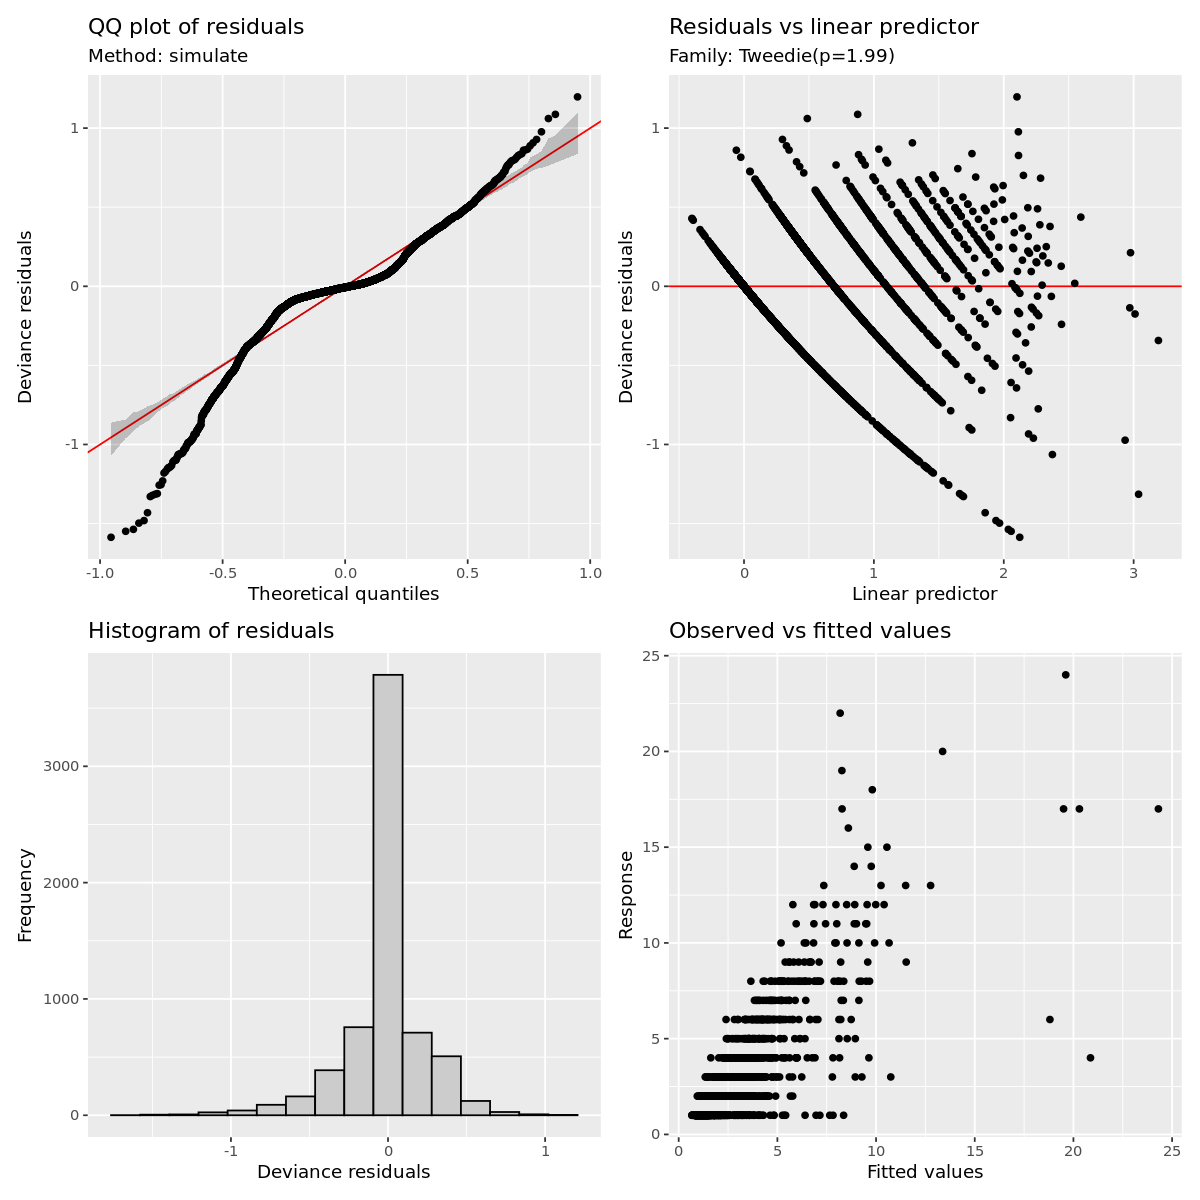

In [142]:
gratia::appraise(mod1)

# section 3: nil-observatiom modeling

In [70]:
nil_data <- read_csv(here('data/processed/spatial_modeling/spatial_modeling_locust_nil_model_data.csv'),
                          show_col_types = FALSE)  |>
    mutate(ecoregion = factor(ecoregion))

In [71]:
mod1 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25) +
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nil_data)

mod2 <- bam(nymph_density_count ~
               s(nitrogen,k=25) +
               s(phosphorus,k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nil_data)

mod3 <- bam(nymph_density_count ~
               s(nymph_density_total_count,k=25) +
               te(longitude,latitude,bs=c('tp','tp'),k=25) +
               s(ecoregion,bs='re'),
           select = TRUE,
           discrete = TRUE,
           nthreads = 20,
          family = tw(),
          data = nil_data)

mod4 <- gam(nymph_density_count ~ 1,
          family = tw(),
          data = nil_data)


In [72]:
# Combine the lists into a single list
models <- list('mod1'= mod1, 'mod2' = mod2, 'mod3'= mod3, 'mod4'= mod4)

# Save the combined list to an RDS file
saveRDS(models, here("output/spatial_modeling/model_objects/locust_nil_models.rds"))

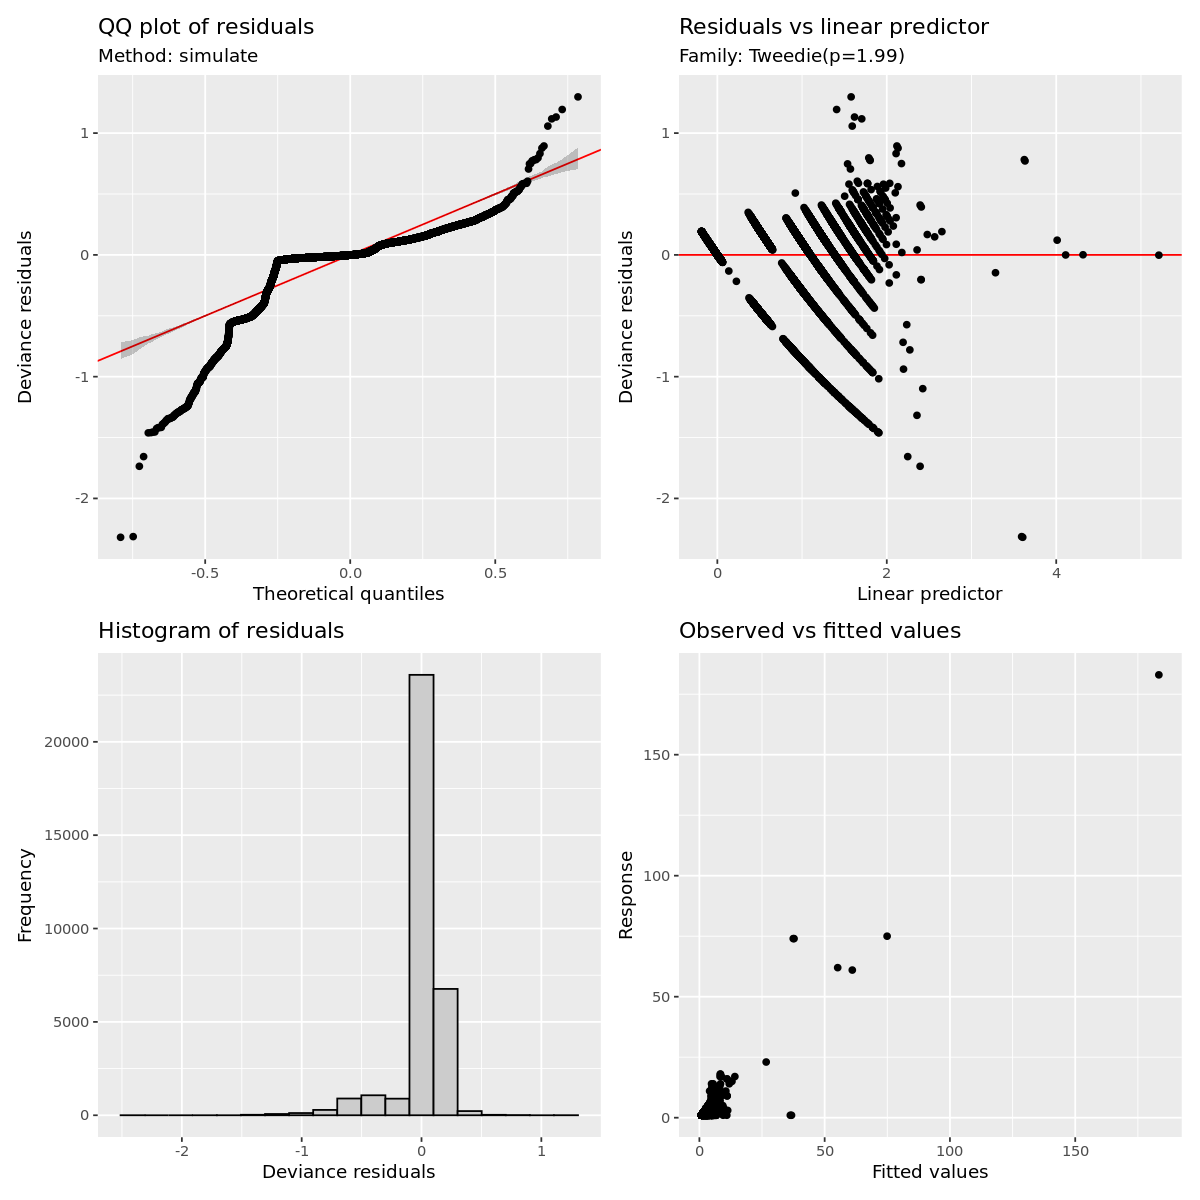

In [73]:
gratia::appraise(models$mod1)

In [74]:
summary(models$mod1)


Family: Tweedie(p=1.99) 
Link function: log 

Formula:
nymph_density_count ~ s(nitrogen, k = 25) + s(phosphorus, k = 25) + 
    s(nymph_density_total_count, k = 25) + te(longitude, latitude, 
    bs = c("tp", "tp"), k = 25) + s(ecoregion, bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.81871    0.02318   78.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                 edf Ref.df        F p-value    
s(nitrogen)                   10.320     24   12.757  <2e-16 ***
s(phosphorus)                  7.853     24    8.971  <2e-16 ***
s(nymph_density_total_count)  23.754     24 3246.948  <2e-16 ***
te(longitude,latitude)       137.248    569    3.167  <2e-16 ***
s(ecoregion)                   2.866     14    0.397  0.0263 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.856   Deviance explained = 88.7%


In [75]:
1+1

[1] 2